In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob
import shutil
import random
import os

In [2]:
physical_devices=tf.config.experimental.list_physical_devices('GPU')
print("Num of GPUs Available: ", len(physical_devices))
if len(physical_devices)>0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print("Running on GPU...")
else:
  print("Running on CPU...")

Num of GPUs Available:  1
Running on GPU...


In [3]:
if not os.path.exists('data/kagglecatsanddogs_5340.zip'):
    !mkdir -p data
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [4]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

In [5]:
os.chdir('data')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for c in random.sample(glob.glob('PetImages/Cat/*'), 500):
        shutil.move(c, 'train/cat')
    for c in random.sample(glob.glob('PetImages/Dog/*'), 500):
        shutil.move(c, 'train/dog')
    for c in random.sample(glob.glob('PetImages/Cat/*'), 100):
        shutil.move(c, 'valid/cat')
    for c in random.sample(glob.glob('PetImages/Dog/*'), 100):
        shutil.move(c, 'valid/dog')
    for c in random.sample(glob.glob('PetImages/Cat/*'), 50):
        shutil.move(c, 'test/cat')
    for c in random.sample(glob.glob('PetImages/Dog/*'), 50):
        shutil.move(c, 'test/dog')

os.chdir('../')

In [6]:
train_path='data/train/'
valid_path='data/train/'
test_path='data/test/'

In [7]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=train_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=test_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10, shuffle=False)


Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
# imgs, labels = next(train_batches)

In [9]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [11]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [13]:
for layer in model.layers:
    layer.trainable=False

In [14]:
model.add(Dense(units=2, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 22s - loss: 0.3997 - accuracy: 0.8590 - val_loss: 0.1672 - val_accuracy: 0.9670 - 22s/epoch - 219ms/step
Epoch 2/5
100/100 - 12s - loss: 0.1302 - accuracy: 0.9710 - val_loss: 0.0961 - val_accuracy: 0.9790 - 12s/epoch - 121ms/step
Epoch 3/5
100/100 - 16s - loss: 0.0865 - accuracy: 0.9800 - val_loss: 0.0714 - val_accuracy: 0.9860 - 16s/epoch - 159ms/step
Epoch 4/5
100/100 - 11s - loss: 0.0667 - accuracy: 0.9850 - val_loss: 0.0553 - val_accuracy: 0.9890 - 11s/epoch - 115ms/step
Epoch 5/5
100/100 - 11s - loss: 0.0532 - accuracy: 0.9890 - val_loss: 0.0460 - val_accuracy: 0.9910 - 11s/epoch - 115ms/step


In [18]:
predictions = model.predict(x=test_batches, verbose=0)

In [19]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [20]:
m_plot_labels = ['cat', 'dog']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=m_plot_labels)

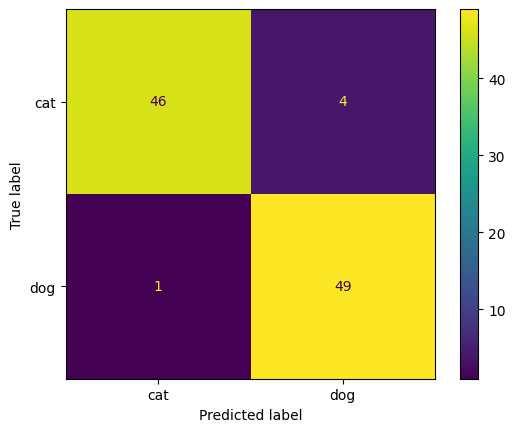

In [21]:
disp.plot()
plt.show()

In [22]:
model.save('model.h5')